# Weekend Movie Trip

## Introduction

The datasets used in this project contain movie review data from MovieLens, a movie recommendation service. The purpose of this project is to use clustering models to find pockets of similar datapoints that can then be used to recommend movies to similar users.

In [211]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.cluster import SpectralClustering 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

## Data

First I upload the data and print it to visually see the organization of said data. The raw data contains multiple files:
- Links - contains movie ID information across multiple websites. This dataset won't be useful for our purposes
- Movies - contains movie Id, title, and genre
- Ratings - Contains movie id, a user's rating and id, and a timestamp
- Tags - contains a movie id, a user's tag/comments on the movie, user id, and a timestamp

I will combine the latter 3 datasets to create a single dataset for use in clustering

In [212]:
dfLinks=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/links.csv")
dfLinks.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [213]:
dfMovies=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/movies.csv")
dfMovies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Since the Ratings and Tag datasets both have an associated timestamp, I rename the timestamp variable in each of these datasets since the values differ per dataset. They become timestampRating and timestampTag for the respective datasets.

In [214]:
dfRatings=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/ratings.csv")
dfRatings["timestampRating"]=dfRatings["timestamp"]
dfRatings.drop(columns =["timestamp"], inplace = True) 
dfRatings.head()

,userId,movieId,rating,timestampRating
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [215]:
dfTags=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-3-Khan/Data/RawData/ml-latest-small/tags.csv")
dfTags["timestampTag"]=dfTags["timestamp"]
dfTags.drop(columns =["timestamp"], inplace = True)
dfTags['tag'] = dfTags['tag'].astype("string")
dfTags.head()

,userId,movieId,tag,timestampTag
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


I run summary statistics on the Ratings and Tag datasets to determine how many users tagged the movies they rated. There is a significant difference here, with 100,936 movies rated, but only 3683 tagged. When I combine the data, I end up dropping the observations that only have ratings, but no tags. This way all of the datapoints have all desired information we want to use in clustering.

In [216]:
dfRatings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   userId           100836 non-null  int64  
 1   movieId          100836 non-null  int64  
 2   rating           100836 non-null  float64
 3   timestampRating  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [217]:
dfTags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userId        3683 non-null   int64 
 1   movieId       3683 non-null   int64 
 2   tag           3683 non-null   string
 3   timestampTag  3683 non-null   int64 
dtypes: int64(3), string(1)
memory usage: 115.2 KB


## Data Cleaning and Merging

The movies dataset has a title field that contains the year the movie was released. I want to create 2 new variables: titleOnly and year so that the year information is stored separately from the title. I do so by splitting on '(' and later remove the ')' from the year variable.

In [218]:
new = dfMovies["title"].str.split("(", n = 1, expand = True)
dfMovies["titleOnly"]=new[0]
dfMovies["year"]=new[1]
dfMovies.head()

,movieId,title,genres,titleOnly,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995)
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995)
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995)
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995)
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995)


I check the datatypes from the movie dataset and convert the objects to strings for ease of cleaning.

In [219]:
dfMovies.dtypes

movieId       int64
title        object
genres       object
titleOnly    object
year         object
dtype: object

In [220]:
dfMovies['year'] = dfMovies['year'].astype("string")
dfMovies['titleOnly'] = dfMovies['titleOnly'].astype("string")
dfMovies['title'] = dfMovies['title'].astype("string")
dfMovies['genres'] = dfMovies['genres'].astype("string")
dfMovies.dtypes

movieId       int64
title        string
genres       string
titleOnly    string
year         string
dtype: object

Here I remove the closing parenthesis by splitting on the ')' character.

In [221]:
new = dfMovies["year"].str.split(")", n = 1, expand = True)
dfMovies["year"]=new[0]
dfMovies.head()

,movieId,title,genres,titleOnly,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995


Now, I merge the Ratings and Tags datasets by matching userId and movieID since the combination of the two should be unique across observations. This new dataset is called dfAll

In [222]:
dfAll=pd.merge(dfRatings, dfTags, left_on=['userId', 'movieId'], right_on=['userId', 'movieId'])
dfAll

,userId,movieId,rating,timestampRating,tag,timestampTag
0,2,60756,5.0,1445714980,funny,1445714994
1,2,60756,5.0,1445714980,Highly quotable,1445714996
2,2,60756,5.0,1445714980,will ferrell,1445714992
3,2,89774,5.0,1445715189,Boxing story,1445715207
4,2,89774,5.0,1445715189,MMA,1445715200
...,...,...,...,...,...,...
3471,606,6107,4.0,1171324428,World War II,1178473747
3472,606,7382,4.5,1171233924,for katie,1171234019
3473,610,3265,5.0,1479542010,gun fu,1493843984
3474,610,3265,5.0,1479542010,heroic bloodshed,1493843978


I now merge the Movies dataset to the already merged dataset (dfAll). When I print it, I notice an error with the way I split the title variable. Recall I split on the '(' character to create the titleOnly and year variables. As you can see below, some movie titles contain parentheses as part of their title, causing the year to contain the subtitle as opposed to the year itself. I will take care of this below by checking the frequency of this problem.

In [223]:
dfAll=pd.merge(dfAll, dfMovies, left_on=['movieId'], right_on=['movieId'])
dfAll

,userId,movieId,rating,timestampRating,tag,timestampTag,title,genres,titleOnly,year
0,2,60756,5.0,1445714980,funny,1445714994,Step Brothers (2008),Comedy,Step Brothers,2008
1,2,60756,5.0,1445714980,Highly quotable,1445714996,Step Brothers (2008),Comedy,Step Brothers,2008
2,2,60756,5.0,1445714980,will ferrell,1445714992,Step Brothers (2008),Comedy,Step Brothers,2008
3,62,60756,3.5,1528934376,comedy,1528934384,Step Brothers (2008),Comedy,Step Brothers,2008
4,62,60756,3.5,1528934376,funny,1528934381,Step Brothers (2008),Comedy,Step Brothers,2008
...,...,...,...,...,...,...,...,...,...,...
3471,606,1948,3.5,1177512639,British,1177512649,Tom Jones (1963),Adventure|Comedy|Romance,Tom Jones,1963
3472,606,5694,3.0,1172968972,70mm,1175638092,Staying Alive (1983),Comedy|Drama|Musical,Staying Alive,1983
3473,606,6107,4.0,1171324428,World War II,1178473747,Night of the Shooting Stars (Notte di San Lore...,Drama|War,Night of the Shooting Stars,"Notte di San Lorenzo, La"
3474,610,3265,5.0,1479542010,gun fu,1493843984,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,Hard-Boiled,Lat sau san taam


In [224]:
dfAll.dtypes

userId               int64
movieId              int64
rating             float64
timestampRating      int64
tag                 string
timestampTag         int64
title               string
genres              string
titleOnly           string
year                string
dtype: object

In [225]:
dfAll.titleOnly = dfAll.titleOnly.str.strip()
dfAll.year = dfAll.year.str.strip()

It can be seen below that year has some missing values, which may create issues when checking for non-numeric year values. These observations with missing year values are dropped, and the index is reset so that the subsequent for loop can execute without error.

In [226]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3476 entries, 0 to 3475
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userId           3476 non-null   int64  
 1   movieId          3476 non-null   int64  
 2   rating           3476 non-null   float64
 3   timestampRating  3476 non-null   int64  
 4   tag              3476 non-null   string 
 5   timestampTag     3476 non-null   int64  
 6   title            3476 non-null   string 
 7   genres           3476 non-null   string 
 8   titleOnly        3476 non-null   string 
 9   year             3473 non-null   string 
dtypes: float64(1), int64(4), string(5)
memory usage: 298.7 KB


In [227]:
dfAll.dropna(subset = ["year"], inplace=True)

In [228]:
dfAll=dfAll.reset_index()

To fix the non-numeric year observations, I simply drop those observations from the dataset. Since there are only 318 of them we are not losing too much information. Ideally, I would have found a more appropriate way to split the title variable so that titles containing parentheses would not be lost from the dataset. By visual observation, the majority of titles containing parentheses were international films (where parentheses contain the original title). Therefore we are losing a category of films by dropping these from the data. 

In [229]:
count=0
for i in range(0,len(dfAll['year'])):
    if(dfAll['year'][i].isnumeric()==False):
        #print(dfAll.iloc[i])
        dfAll.drop([i],inplace=True, axis=0)
        count=count+1
        
            
print('Times year variable contains non-numeric values =', count)

Times year variable contains non-numeric values = 318


In [230]:
dfAll=dfAll.reset_index()

I now verify there are no more missing values in the dataset:

In [231]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3155 entries, 0 to 3154
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   level_0          3155 non-null   int64  
 1   index            3155 non-null   int64  
 2   userId           3155 non-null   int64  
 3   movieId          3155 non-null   int64  
 4   rating           3155 non-null   float64
 5   timestampRating  3155 non-null   int64  
 6   tag              3155 non-null   string 
 7   timestampTag     3155 non-null   int64  
 8   title            3155 non-null   string 
 9   genres           3155 non-null   string 
 10  titleOnly        3155 non-null   string 
 11  year             3155 non-null   string 
dtypes: float64(1), int64(6), string(5)
memory usage: 295.9 KB


In [232]:
dfAll.head()

,level_0,index,userId,movieId,rating,timestampRating,tag,timestampTag,title,genres,titleOnly,year
0,0,0,2,60756,5.0,1445714980,funny,1445714994,Step Brothers (2008),Comedy,Step Brothers,2008
1,1,1,2,60756,5.0,1445714980,Highly quotable,1445714996,Step Brothers (2008),Comedy,Step Brothers,2008
2,2,2,2,60756,5.0,1445714980,will ferrell,1445714992,Step Brothers (2008),Comedy,Step Brothers,2008
3,3,3,62,60756,3.5,1528934376,comedy,1528934384,Step Brothers (2008),Comedy,Step Brothers,2008
4,4,4,62,60756,3.5,1528934376,funny,1528934381,Step Brothers (2008),Comedy,Step Brothers,2008


## Adding more features

I want to use DBSCAN and Spectral Clustering for my cluster analysis; therefore I want to convert any string variables into numerical values via conversion to categories. First I will do this for the genres variable. I create a new variable called genreCat (for genre category). I then generate the category codes using .cat.codes which autogenerates values according to the strings in the genres variable.

In [233]:
dfAll["genreCat"] = dfAll["genres"].astype('category')

In [234]:
dfAll["genreCat"] = dfAll["genreCat"].cat.codes

As seen below, there are 331 categories. Though there are only 18 genres in this dataset, some movies have more than one genre associated with it. Therefore the number of genre categories represents all the combinations of genres represented in the dataset.

In [235]:
dfAll["genreCat"].describe()

count    3155.000000
mean      193.746117
std        89.077214
min         0.000000
25%       129.500000
50%       205.000000
75%       263.000000
max       330.000000
Name: genreCat, dtype: float64

I now want to convert the datatype of genreCat and year to integers. genreCat was previously of category type and year was of string type.

In [236]:
dfAll["genreCat"] = dfAll["genreCat"].astype('int')
dfAll["year"] = dfAll["year"].astype('int')

In [237]:
dfAll.dtypes

level_0              int64
index                int64
userId               int64
movieId              int64
rating             float64
timestampRating      int64
tag                 string
timestampTag         int64
title               string
genres              string
titleOnly           string
year                 int64
genreCat             int64
dtype: object

I want to further clean the data by dropping any movies produced before 1900. It can be seen below that the minimum year value is "500". We know that no movies were produced in the year 500 so we drop movies produced prior to 1900 and now find the min to be 1921. Only 8 observations contained a movie produced before 1900.

In [238]:
dfAll['year'].describe()

count    3155.000000
mean     1989.920761
std        77.503293
min       500.000000
25%      1989.000000
50%      1998.000000
75%      2006.000000
max      2018.000000
Name: year, dtype: float64

In [239]:
count=0
for i in range(0,len(dfAll['year'])):
    if(dfAll['year'][i] < 1900):
        #print(dfAll.iloc[i])
        dfAll.drop([i],inplace=True, axis=0)
        count=count+1
        
print('Times year was less than 1900 =', count)

Times year was less than 1900 = 8


Here I use the Vader Sentiment algorithm to create a sentiment variable for the tag. The variable is called tagSentiment and provides a score between -1 and 1. Scores less than 0 indicate negative sentiment, a 0 score indicates neutral sentiment, and scores greater than 0 indicate positive sentiment. Any sentiments associated with movies can be useful when recommending movies to other users. Users with similar tags may like movies from other users with similar tags.

In [240]:
analyzer=SentimentIntensityAnalyzer()
dfAll['tagSentiment'] = [analyzer.polarity_scores(v)['compound'] for v in dfAll['tag']]
dfAll
#sentence = "funny"
#analyzer.polarity_scores(sentence)

,level_0,index,userId,movieId,rating,timestampRating,tag,timestampTag,title,genres,titleOnly,year,genreCat,tagSentiment
0,0,0,2,60756,5.0,1445714980,funny,1445714994,Step Brothers (2008),Comedy,Step Brothers,2008,189,0.4404
1,1,1,2,60756,5.0,1445714980,Highly quotable,1445714996,Step Brothers (2008),Comedy,Step Brothers,2008,189,0.0000
2,2,2,2,60756,5.0,1445714980,will ferrell,1445714992,Step Brothers (2008),Comedy,Step Brothers,2008,189,0.0000
3,3,3,62,60756,3.5,1528934376,comedy,1528934384,Step Brothers (2008),Comedy,Step Brothers,2008,189,0.3612
4,4,4,62,60756,3.5,1528934376,funny,1528934381,Step Brothers (2008),Comedy,Step Brothers,2008,189,0.4404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150,3465,3468,573,52712,0.5,1248842748,HORRIBLE ACTING,1186722048,"Invisible, The (2007)",Crime|Drama|Fantasy|Mystery|Thriller,"Invisible, The",2007,236,-0.5423
3151,3466,3469,573,52712,0.5,1248842748,interesting,1186722060,"Invisible, The (2007)",Crime|Drama|Fantasy|Mystery|Thriller,"Invisible, The",2007,236,0.4019
3152,3467,3470,606,1357,4.0,1173823837,music,1176765393,Shine (1996),Drama|Romance,Shine,1996,290,0.0000
3153,3468,3471,606,1948,3.5,1177512639,British,1177512649,Tom Jones (1963),Adventure|Comedy|Romance,Tom Jones,1963,134,0.0000


In [241]:
#dfAll.to_csv('FinalData.csv')

## Clustering

I chose to use DBSCAN and Spectral Clustering. I chose DBSCAN because the method makes sense conceptually and is relatively simple to interpret. I chose Spectral Clustering because it has been shown to produce accurate results and is conceptually interesting because it treats each datapoint as a graph node therefore converting the clustering problem into a graph partitioning problem.

For graphing purposes, I chose two variables on which to run the models. Later on I do run DBSCAN on 4 features just to see the results, but don't graph it.

Before running the models, I normalize the variables I want to use. First I place them in a renamed dataframe dfTest, then scale the data, and then I normalized the dataframe so that it follows a Gaussian distribution. I wanted to scale the data so that the parameters used for DBSCAN affect both variables equally (i.e. the eps value).

#### Needed Function Definitions
The first 2 function definitions are used to generate the color vectors used for my cluster graphs. In the DBSCAN plots, the noise values are always colored black. genColorsDBSCAN generates the colors for the DBSCAN graphs and genColorsSpec generates the colors for the Spectral Clustering graphs. Both use random number generators to generate the rbg colors used.

The last function definition is used to scale and normalize the data (discussed above)

In [150]:
def genColorsDBSCAN(n_clusters_):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    colors[-1]=(0,0,0)
    for i in range(0,n_clusters_):
        #while r==0 and b==0 and g==0:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors[i]=color
        #print(colors[i])
    
    cvec=[colors[label] for label in labels]
    return cvec

In [151]:
def genColorsSpec(n_clusters_spec):
    colors={}
    r = 0
    b = 0
    g = 0
    color = (r, g, b)

    #colors[-1]=(0,0,0)
    for i in range(0,n_clusters_spec):
        #while r==0 and b==0 and g==0:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        colors[i]=color
        #print(colors[i])

    
    
    cvec = [colors[label] for label in labels_rbf] 
    return cvec

In [152]:
def scaleAndNormalize(var1, var2):
    # Scaling the data to bring all the attributes to a comparable level 
    scaler = StandardScaler() 
    dfTest_scaled = scaler.fit_transform(dfTest) 
  
    # Normalizing the data so that  
    # the data approximately follows a Gaussian distribution 
    dfTest_normalized = normalize(dfTest_scaled) 
  
    # Converting the numpy array into a pandas DataFrame 
    dfTest_normalized = pd.DataFrame(dfTest_normalized)
    dfTest_normalized

    dfTest_normalized.columns = [var1, var2]
    return dfTest_normalized

### Clustering Year and Genre 

First, I clustered based on year and genre (by using the genre category variable I created earlier). I chose to cluster on year and genre because I reason that people who like movies from certain years and genre combinations may like other movies from similar years and categories.

#### DBSCAN

In [153]:
dfTest=dfAll[['year','genreCat']]

dfTest_normalized=scaleAndNormalize('year', 'genreCat')
dfTest_normalized

,year,genreCat
0,0.997546,-0.070018
1,0.997546,-0.070018
2,0.997546,-0.070018
3,0.997546,-0.070018
4,0.997546,-0.070018
...,...,...
3142,0.827046,0.562134
3143,0.827046,0.562134
3144,0.110744,0.993849
3145,-0.923569,-0.383433


Here I run the DBSCAN algorithm with an eps value of 0.02 and minimum sample per cluster of 5. I chose this eps because larger values resulted in a single cluster. Since the values in the dataset (as seen above) are all very small, I needed a smaller eps value to account for this. I chose a relatively random min_sample value to see the results and because I wanted at least 5 observations per cluster so they can be seen on the graph.

The result is 41 clusters with 25 noise observations. In other words, only 25 observations were not added to a cluster by the algorithm. The graphed results can be seen below.

In [154]:
dbsc = DBSCAN(eps = 0.02, min_samples = 5).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, -1}
Estimated number of clusters: 41
Estimated number of noise points: 25


I now plot the data in a scatter plot. Each cluster is colored a different color. The noise values (values not placed in a cluster) are always colored black. It can be seen below that there are definite clusters of data. Along the x axis is the year and the y axis is the genre categories. I first graph the normalized values to see what they look like. And then I chose to graph the un-normalized values for ease of interpretation. I will graph the raw values for the rest of my analysis.

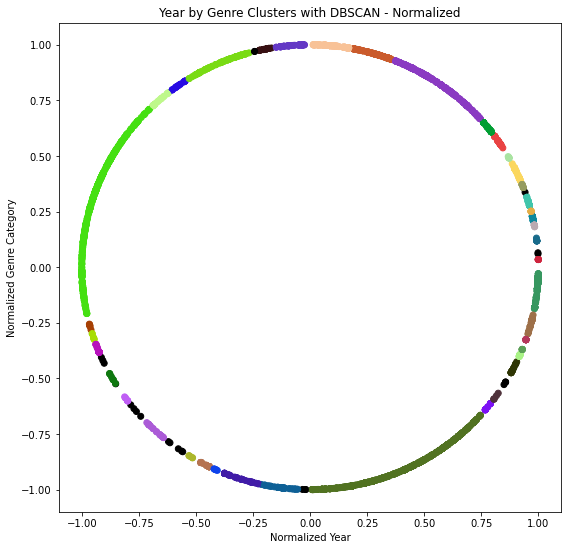

In [155]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest_normalized['year'], dfTest_normalized['genreCat'], c=cvec)
plt.title('Year by Genre Clusters with DBSCAN - Normalized')
plt.xlabel('Normalized Year')
plt.ylabel('Normalized Genre Category')

plt.show()

Text(0, 0.5, 'Genre Category')

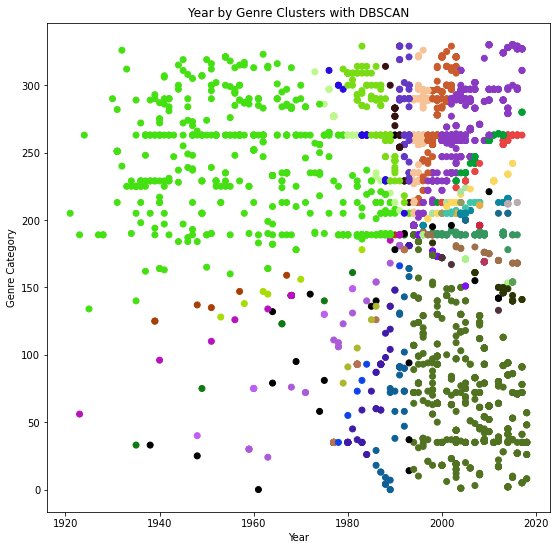

In [156]:
import random

#cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['year'], dfTest['genreCat'], c=cvec)
plt.title('Year by Genre Clusters with DBSCAN')
plt.xlabel('Year')
plt.ylabel('Genre Category')

#### Spectral Clustering

Since DBSCAN resulted in 41 clusters, I wanted to see the cluster results for Spectral clustering using 41 clusters as well. The downside to Spectral Clustering is--it doesn't scale well. Running it with 8 clusters was quick, but running it with 35 clusters takes a lot more time. The results can be seen below in the graph. The clusters look cleaner and more defined than the DBSCAN results. The tradeoff here is time versus relative accuracy.

In [157]:
# Building the clustering model 
n_clusters_spec=41
spectral_model_rbf = SpectralClustering(n_clusters = 41, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(dfTest_normalized) 

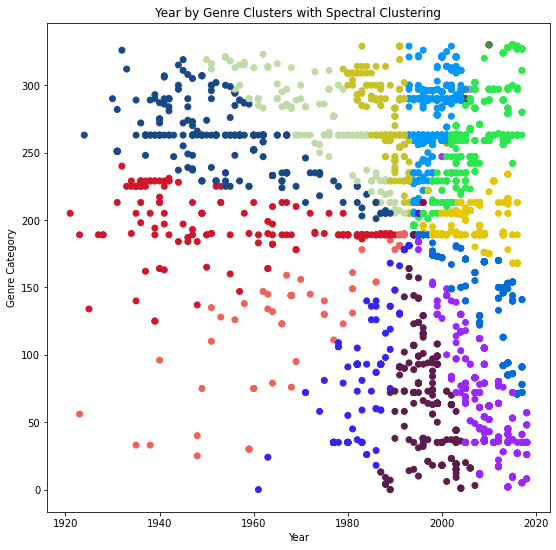

In [158]:
cvec=genColorsSpec(n_clusters_spec)    
  
plt.figure(figsize =(9, 9)) 
plt.scatter(dfTest['year'], dfTest['genreCat'], c = cvec) 
plt.title('Year by Genre Clusters with Spectral Clustering')
plt.xlabel('Year')
plt.ylabel('Genre Category')
plt.show() 

### Clustering Rating and Genre 

Next, I clustered based on rating and genre (by using the genre category variable I created earlier). I chose to cluster on rating and genre because I wanted to see if there was any interesting clustering among ratings and genres. If someone watched a movie that was rated a 1, they likely wouldn't want to watch another movie rated a 1. Typically you would want to watch a movie with a higher rating unless you prefer bad movies. Therefore, recommending movies based on these ratings clusters might not be very accurate.

#### DBSCAN

In [183]:
dfTest=dfAll[['rating','genreCat']]

dfTest_normalized=scaleAndNormalize('rating', 'genreCat')
dfTest_normalized

,rating,genreCat
0,0.998946,-0.045906
1,0.998946,-0.045906
2,0.998946,-0.045906
3,-0.995862,-0.090878
4,-0.995862,-0.090878
...,...,...
3142,-0.993123,0.117075
3143,-0.993123,0.117075
3144,-0.002536,0.999997
3145,-0.653011,-0.757349


In [184]:
dbsc = DBSCAN(eps = 0.04, min_samples = 5).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1}
Estimated number of clusters: 19
Estimated number of noise points: 6


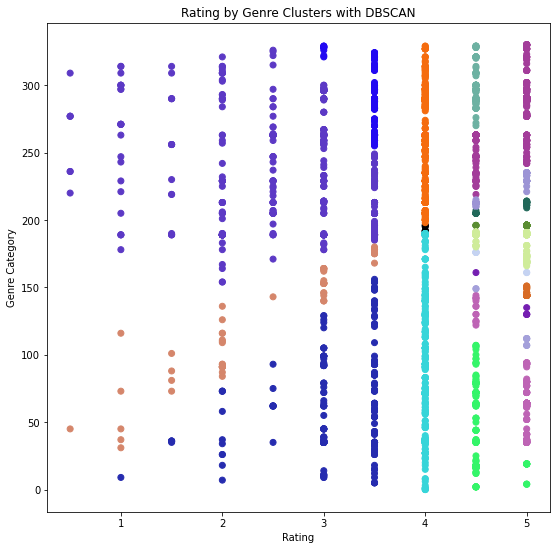

In [185]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['rating'], dfTest['genreCat'], c=cvec)
plt.title('Rating by Genre Clusters with DBSCAN')
plt.xlabel('Rating')
plt.ylabel('Genre Category')

plt.show()

#### Spectral Clustering

I used fewer clusters than DBSCAN here because of the high complexity of Spectral Clustering. When I tried to run it with 19 clusters to match DBSCAN, it seemed unable to complete. I conjecture this is because of the layout of the data in this case. Here the clusters do look similar between DBSCAN and Spectral clustering.

In [190]:
# Building the clustering model 
n_clusters_spec=12
spectral_model_rbf = SpectralClustering(n_clusters = 12, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(dfTest_normalized) 

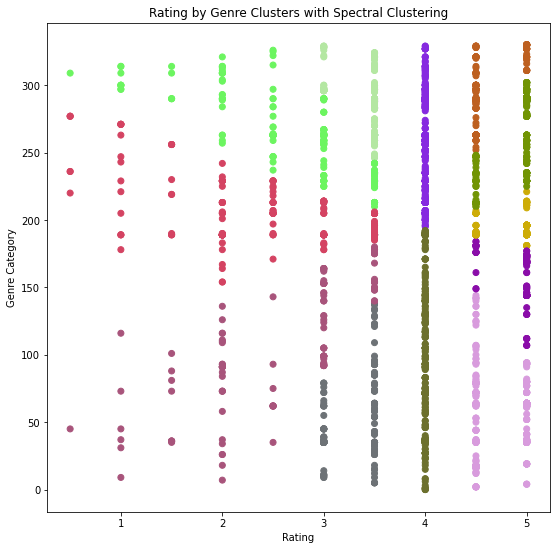

In [191]:
cvec=genColorsSpec(n_clusters_spec)    
  
plt.figure(figsize =(9, 9)) 
plt.scatter(dfTest['rating'], dfTest['genreCat'], c = cvec) 
plt.title('Rating by Genre Clusters with Spectral Clustering')
plt.xlabel('Rating')
plt.ylabel('Genre Category')
plt.show() 

### Clustering Tag Sentiment and Rating 

Next, I clustered on tag sentiment and rating. Recall a positive tag sentiment score indicates positive sentiment, close to 0 is neutral, and a negative score is negative sentiment. I chose to cluster on sentiment and rating because I reason if someone tends to have similar sentiment and ratings as another user, they might like similar movies.

#### DBSCAN

In [204]:
dfTest=dfAll[['tagSentiment','rating']]

dfTest_normalized=scaleAndNormalize('tagSentiment', 'rating')
dfTest_normalized

,tagSentiment,rating
0,0.862800,0.505546
1,0.027999,0.999608
2,0.027999,0.999608
3,0.941343,-0.337450
4,0.959118,-0.283005
...,...,...
3142,-0.502238,-0.864729
3143,0.406048,-0.913852
3144,0.996383,-0.084981
3145,0.055535,-0.998457


In [205]:
dbsc = DBSCAN(eps = 0.06, min_samples = 5).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
Estimated number of clusters: 16
Estimated number of noise points: 34


One cluster I found interesting from this analysis is the cluster that has high rating and negative sentiment. When I looked at the data, these observations were movies that tended to be dark. Therefore the negative sentiment score was not negative because the movie was badly rated, but rather was negative because dark movies contain "negative" tags as measured by the sentiment algorithm. One example was Pulp Fiction. As a result I think these clusters could still be useful in recommending movies.

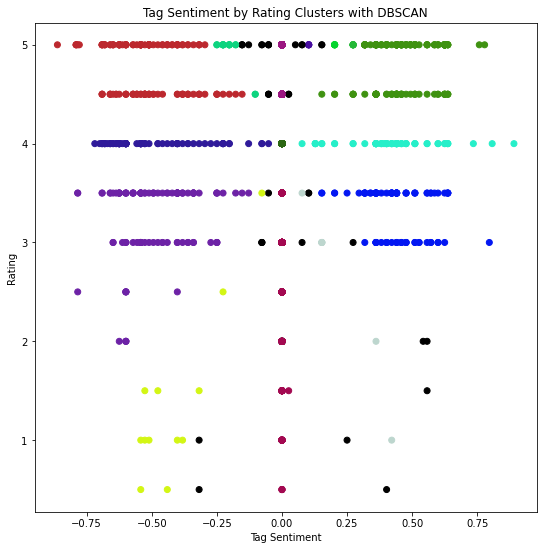

In [206]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['tagSentiment'], dfTest['rating'], c=cvec)
plt.title('Tag Sentiment by Rating Clusters with DBSCAN')
plt.xlabel('Tag Sentiment')
plt.ylabel('Rating')

plt.show()

#### Spectral Clustering

I again used a smaller number of clusters compared to DBSCAN because of Spectral Clustering's complexity. The results still show similar clusters compared the the DBSCAN results.

In [209]:
# Building the clustering model 
n_clusters_spec=10
spectral_model_rbf = SpectralClustering(n_clusters = 10, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(dfTest_normalized) 

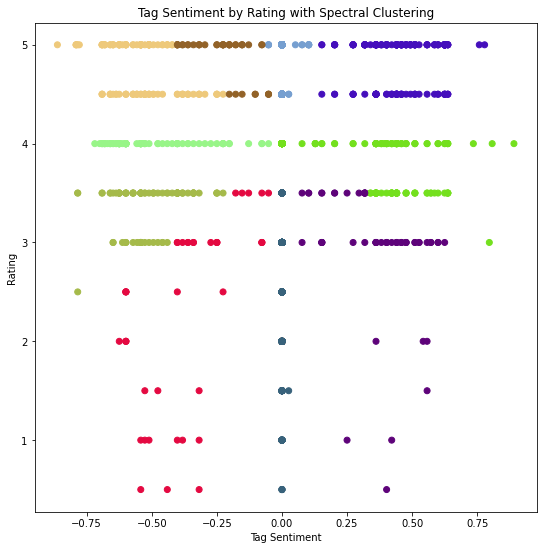

In [210]:
cvec=genColorsSpec(n_clusters_spec)    
  
plt.figure(figsize =(9, 9)) 
plt.scatter(dfTest['tagSentiment'], dfTest['rating'], c = cvec) 
plt.title('Tag Sentiment by Rating with Spectral Clustering')
plt.xlabel('Tag Sentiment')
plt.ylabel('Rating')
plt.show() 

### Clustering Tag Sentiment and Genre 

Finally, I clustered on tag sentiment and genre. I chose to cluster on sentiment and genre because I reason if someone tends to have similar sentiment as another user, they would like movies of similar genres as those users. The resuls proved interesting with a cluster containing all genres and neutral sentiment. It seems there are a lot of users who rated movies with neutral sentiment. Therefore they might like movies of any genre as long as the sentiment is neutral.

#### DBSCAN

In [169]:
dfTest=dfAll[['tagSentiment','genreCat']]

dfTest_normalized=scaleAndNormalize('tagSentiment', 'genreCat')
dfTest_normalized

,tagSentiment,genreCat
0,0.999638,-0.026917
1,0.520452,-0.853891
2,0.520452,-0.853891
3,0.999465,-0.032695
4,0.999638,-0.026917
...,...,...
3142,-0.980017,0.198915
3143,0.966560,0.256442
3144,0.029716,0.999558
3145,0.047903,-0.998852


In [170]:
dbsc = DBSCAN(eps = 0.02, min_samples = 5).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, -1}
Estimated number of clusters: 35
Estimated number of noise points: 89


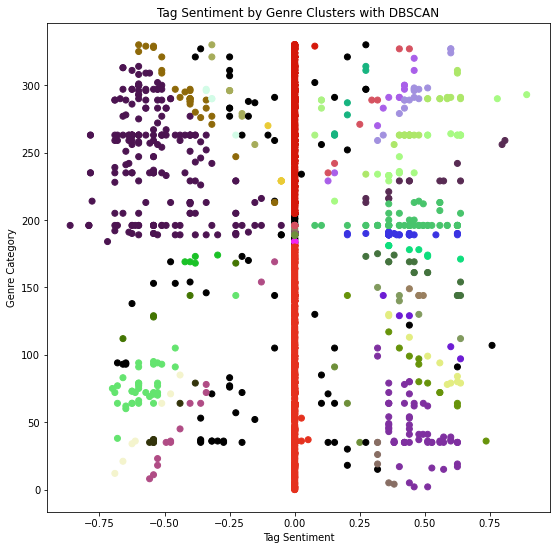

In [171]:
cvec=genColorsDBSCAN(n_clusters_)

plt.figure(figsize=(9,9))
plt.scatter(dfTest['tagSentiment'], dfTest['genreCat'], c=cvec)

plt.title('Tag Sentiment by Genre Clusters with DBSCAN')
plt.xlabel('Tag Sentiment')
plt.ylabel('Genre Category')

plt.show()

#### Spectral Clustering

Once again I chose to use the same number of clusters as DBSCAN for comparison purposes. The results show much cleaner clusters than DBSCAN.

In [175]:
# Building the clustering model 
n_clusters_spec=35
spectral_model_rbf = SpectralClustering(n_clusters = 35, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(dfTest_normalized) 

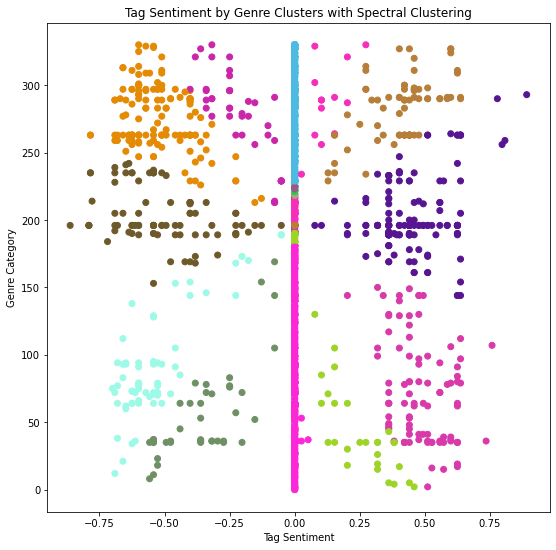

In [178]:
cvec=genColorsSpec(n_clusters_spec) 
  
plt.figure(figsize =(9, 9)) 
plt.scatter(dfTest['tagSentiment'], dfTest['genreCat'], c = cvec) 
plt.title('Tag Sentiment by Genre Clusters with Spectral Clustering')
plt.xlabel('Tag Sentiment')
plt.ylabel('Genre Category')
plt.show() 

## Running DBSCAN with more than 2 variables:

I chose to run DBSCAN with 4 variables to see if the algorithm was able to produce clean clusters. It is difficult to determine how nice the clusters are without being able to plot them, but the algorithm was still able to produce 16 clusters with only 134 noise observations. Users who like movies of similar sentiment, year ranges, rating ranges, and genres as other users would likely enjoy similar movies as those users. It would be interesting to see which observations were clustered together here.

In [179]:
dfTest=dfAll[['tagSentiment','genreCat', 'year', 'rating']]

# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
dfTest_scaled = scaler.fit_transform(dfTest) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
dfTest_normalized = normalize(dfTest_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
dfTest_normalized = pd.DataFrame(dfTest_normalized)
dfTest_normalized

dfTest_normalized.columns = ['tagSentiment','genreCat', 'year', 'rating']
dfTest_normalized

,tagSentiment,genreCat,year,rating
0,0.818898,-0.022050,0.314149,0.479823
1,0.023410,-0.038408,0.547207,0.835788
2,0.023410,-0.038408,0.547207,0.835788
3,0.861687,-0.028188,0.401602,-0.308895
4,0.899858,-0.024230,0.345208,-0.265519
...,...,...,...,...
3142,-0.494178,0.100304,0.147573,-0.850852
3143,0.398791,0.105805,0.155667,-0.897518
3144,0.029533,0.993412,0.110695,-0.002519
3145,0.017457,-0.363997,-0.876755,-0.313850


In [180]:
dbsc = DBSCAN(eps = 0.2, min_samples = 5).fit(dfTest_normalized)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

print(set(labels))

n_clusters_=len(set(labels))
n_noise_=list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, -1}
Estimated number of clusters: 16
Estimated number of noise points: 134


## Conclusion

Overall, both models produced similar clustering results. The Spectral Clustering model produced cleaner results with more delineated clusters, but it was slower to execute as a result of higher complexity. The DBSCAN algorithm still produced reasonable results in most situations and was able to execute faster. There is a definite tradeoff between time complexity and accuracy of the models.

I would have liked to run this analysis on the larger version of this dataset. Since I dropped observations that did not have tags, I ended up with just over 3,000 observations which is short of the ideal minimum of 10,000 observations. Any resulting movie recommendations would be less robust in this smaller dataset than a larger version.